# MOSFET gm/ID Evaluation Script for IHP SG13G2

**Copyright 2024 Boris Murmann and Harald Pretl**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

This notebook displays various important metrics for the SG13G2 CMOS technology. The corresponding Xschem testbenches are named `techsweep_sg13g2_hv_nmos.sch` and `techsweep_sg13g2_hv_pmos.sch` (to be found in the `xschem` folder).

In [1]:
devices = ['sg13_hv_nmos', 'sg13_hv_pmos']
choice = 0 # select which device to plot, start from 0

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# widths used for characterization
w = np.array([5, 5])

In [3]:
# # read ngspice data
# df_raw = pd.read_csv('./techsweep_'+devices[choice]+'.txt', sep=r'\s+')
# par_names = df_raw.columns.to_list()
# par_prefix = par_names[1].split('[')[0]

# # remove extra headers in file body and unwanted columns
# #df_raw = df_raw[~df_raw['v-sweep'].str.contains('v-sweep')]
# df = df_raw.drop(['frequency', 'frequency.1'], axis=1)
# df = df.apply(pd.to_numeric)

# # rename columns for readability
# df.columns = df.columns.str.removeprefix(par_prefix+'[')
# df.columns = df.columns.str.replace(par_prefix[1:], '')
# df.columns = df.columns.str.removesuffix(']')

matfile = devices[choice] + ".mat"   # e.g. sg13_hv_nmos.mat
m = loadmat(matfile)

# structure saved like: savemat(devices[choice]+'.mat', {devices[choice]: dic})
s = m[devices[choice]]  # MATLAB struct

# helper to access MATLAB struct fields cleanly
def fld(name):
    return s[name][0, 0]

# sweep vectors
l   = fld("L").squeeze()
vgs = fld("VGS").squeeze()
vds = fld("VDS").squeeze()
vsb = fld("VSB").squeeze()

# 4D arrays in order: [L, VGS, VDS, VSB]
ID  = fld("ID")
VT  = fld("VT")
GM  = fld("GM")
GMB = fld("GMB")
GDS = fld("GDS")
CGG = fld("CGG")
CGB = fld("CGB")
CGD = fld("CGD")
CGS = fld("CGS")
CDD = fld("CDD")
CSS = fld("CSS")
STH = fld("STH")
SFL = fld("SFL")

# rebuild df so the rest of your plotting code still works
# create mesh in the same sweep order as txt_to_mat assumes: L, VGS, VDS, VSB
L_grid, VGS_grid, VDS_grid, VSB_grid = np.meshgrid(l, vgs, vds, vsb, indexing="ij")

df = pd.DataFrame({
    "l":   L_grid.ravel(order="C"),
    "vgs": VGS_grid.ravel(order="C"),
    "vds": VDS_grid.ravel(order="C"),
    "vsb": VSB_grid.ravel(order="C"),
    "ids": ID.ravel(order="C"),
    "vth": VT.ravel(order="C"),
    "gm":  GM.ravel(order="C"),
    "gmb": GMB.ravel(order="C"),
    "gds": GDS.ravel(order="C"),
    "cgg": CGG.ravel(order="C"),
    "cgb": CGB.ravel(order="C"),
    "cgd": CGD.ravel(order="C"),
    "cgs": CGS.ravel(order="C"),
    "cdd": CDD.ravel(order="C"),
    "css": CSS.ravel(order="C"),
    "sid": STH.ravel(order="C"),
    "sfl": SFL.ravel(order="C"),
})

# round sweep vectors to easily addressable values
# df['l'] = df['l'].apply(lambda x: round(x/1e-6, 3))
df['l']  = df['l'].apply(lambda x: round(x, 3))
df['vgs'] = df['vgs'].apply(lambda x: round(x, 3))
df['vds'] = df['vds'].apply(lambda x: round(x, 3))
df['vsb'] = df['vsb'].apply(lambda x: round(x, 3))

print(df.head())
print(df.columns)
print("Unique L:", np.unique(df["l"])[:5])
# Note on noise data: 
# 1.: sid, sfl are thermal and flicker noise current densities at 1 Hz in A^2/Hz from operating point data

      l  vgs    vds  vsb           ids     vth            gm           gmb  \
0  0.45  0.0  0.000 -0.0  0.000000e+00  0.6339  0.000000e+00 -0.000000e+00   
1  0.45  0.0  0.000  0.2  0.000000e+00  0.6750  0.000000e+00 -0.000000e+00   
2  0.45  0.0  0.000  0.4  0.000000e+00  0.7124  0.000000e+00 -0.000000e+00   
3  0.45  0.0  0.000  0.6  0.000000e+00  0.7469  0.000000e+00 -0.000000e+00   
4  0.45  0.0  0.025 -0.0  5.484000e-14  0.6339  1.351000e-12  6.254000e-13   

            gds           cgg           cgb           cgd           cgs  \
0  3.383000e-12  6.279000e-15 -2.361000e-15  1.958859e-15  1.958859e-15   
1  4.356000e-13  5.916000e-15 -1.999000e-15  1.958424e-15  1.958424e-15   
2  7.828000e-14  5.689000e-15 -1.772000e-15  1.958246e-15  1.958246e-15   
3  1.810000e-14  5.530000e-15 -1.613000e-15  1.958157e-15  1.958157e-15   
4  1.312000e-12  6.276000e-15 -2.361000e-15  1.944050e-15  1.970580e-15   

            cdd           css           sid           sfl  
0  3.653000e-15  3.6

In [4]:
# sweep variable vectors
l = np.unique(abs(df['l']))
vgs = np.unique(abs(df['vgs']))
vds = np.unique(abs(df['vds']))
vsb = np.unique(abs(df['vsb']))

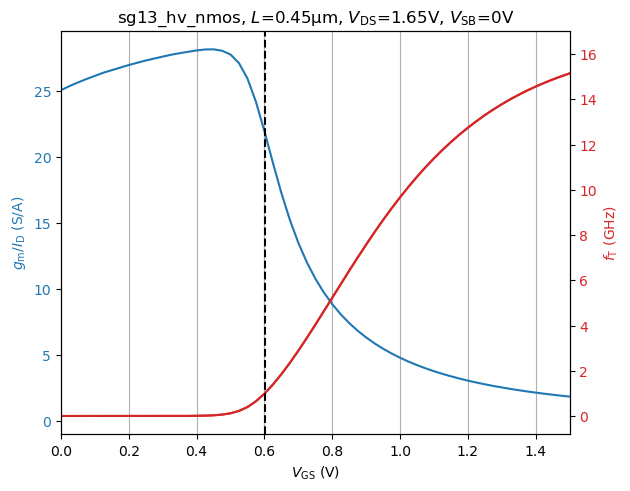

In [5]:
# plot gm/ID and fT versus gate bias
#| label: fig-nmos-gmid-ft-vs-vgs
#| fig-cap: $g_m/I_D$ and $f_T$ as a function of the gate-source voltage.
L1 = min(l)
# VDS1=1.65;
VDS1=np.max(vds)/2
VSB1=0
# df1 = df.loc[(df['l'] == L1) & (abs(df['vds']) == VDS1) & (abs(df['vsb']) == VSB1)]
df1 = df.loc[
    (df["l"] == L1)
    & (np.isclose(np.abs(df["vds"]), VDS1))
    & (np.isclose(np.abs(df["vsb"]), VSB1))
].copy()

df1 = df1.sort_values("vgs")

vgs = df1["vgs"].to_numpy()
gm_id1 = df1["gm"].to_numpy() / df1["ids"].to_numpy()
# cgg1 = df1['cgg'].values + df1['cgdol'].values+df1['cgsol'].values
cgg1 = df1['cgg'].values

if 'cgdol' in df1.columns:
    cgg1 = cgg1 + df1['cgdol'].values
if 'cgsol' in df1.columns:
    cgg1 = cgg1 + df1['cgsol'].values
    
# ft1 = df1['gm'].values/cgg1/2/np.pi
# ft2 = df1['fug'].values
# ft1 = df1['gm'].values / cgg1 / (2*np.pi)
ft1 = df1["gm"].to_numpy() / df1["cgg"].to_numpy() / (2*np.pi)
ft2 = ft1

fig, ax1 = plt.subplots()
ax1.grid(axis='x')
ax1.set_xlabel(r'$V_\mathrm{GS}$ (V)')
color = 'tab:blue'
ax1.set_ylabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)', color=color)
ax1.plot(vgs, gm_id1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$f_\mathrm{T}$ (GHz)', color=color)
ax2.plot(vgs, ft1/1e9, color=color)
ax2.plot(vgs, ft2/1e9, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title(devices[choice]+', $L$='+str(L1)+r'µm, $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.xlim(0, 1.5)
plt.axvline(x = df1['vth'].values[0], color='k', linestyle='--')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_gmID_fT_VGS.eps", bbox_inches='tight')

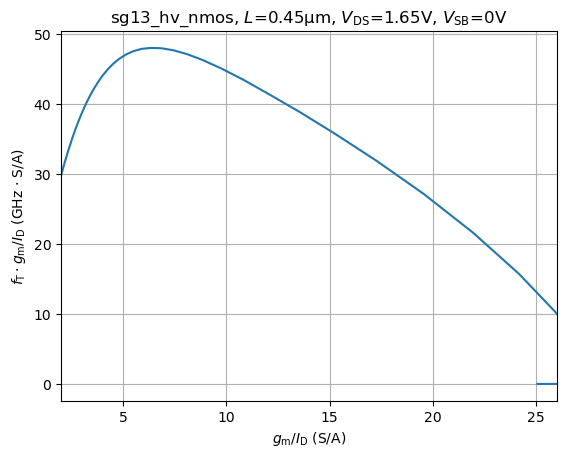

In [6]:
# plot product of gm/ID and fT versus gm/ID
fig, ax1 = plt.subplots()
plt.plot(gm_id1, gm_id1*ft1/1e9)
plt.xlim(2, 26)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{T} \cdot g_\mathrm{m}/I_\mathrm{D}$ (GHz $\cdot$ S/A)')
plt.title(devices[choice]+', $L$='+str(L1)+r'µm, $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_fTgmID_gmID.eps", bbox_inches='tight')

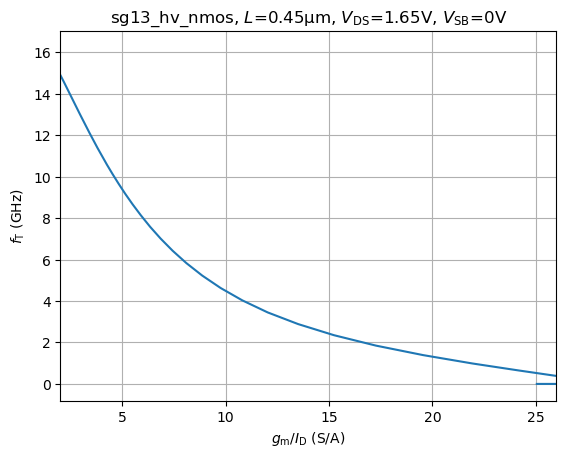

In [7]:
# plot fT versus gm/ID
#| label: fig-nmos-ft-vs-gmid
#| fig-cap: $f_T$ vs. $g_m/I_D$.
plt.plot(gm_id1, ft1/1e9)
plt.xlim(2, 26)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{T}$ (GHz)')
plt.title(devices[choice]+', $L$='+str(L1)+r'µm, $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()

In [8]:
# plot fT versus gm/ID for all L
#| label: fig-nmos-ft-vs-gmid-vs-l
#| fig-cap: $f_T$ vs. $g_m/I_D$ as a function of $L$.
VDS2=np.max(vds)/2
VSB2=0
df2 = df.loc[(abs(df['vds']) == VDS2) & (abs(df['vsb']) == VSB2)]
gm_id2 = df2['gm'].values/df2['ids'].values
gm_id2 = np.reshape(gm_id2, (len(vgs), -1), order='F')
ft2 = df2['gm'].values/(df2['cgg'].values+df2['cgdol'].values+df2['cgsol'].values)/2/np.pi
ft2 = np.reshape(ft2, (len(vgs), -1), order='F')

fig, ax = plt.subplots()
ax.plot(gm_id2, ft2/1e9)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{T}$ (GHz)')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_fT_gmID.eps", bbox_inches='tight')

KeyError: 'cgdol'

In [ ]:
# plot gm/gds versus gm/ID for all L
#| label: fig-nmos-gmgds-vs-gmid-vs-l
#| fig-cap: $g_m/g_{ds}$ vs. $g_m/I_D$ as a function of $L$.
gm_gds2 = df2['gm'].values/df2['gds'].values
gm_gds2 = np.reshape(gm_gds2, (len(vgs), -1), order='F')

fig, ax = plt.subplots()
ax.plot(gm_id2, gm_gds2)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.ylim(0, 200)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$g_\mathrm{m}/g_\mathrm{ds}$ (V/V)')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.grid()
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_gmgds_gmID.eps", bbox_inches='tight')

In [ ]:
# plot Id/W (Jd) versus gm/ID for all L
#| label: fig-nmos-jd-vs-gmid-vs-l
#| fig-cap: $I_D/W$ vs. $g_m/I_D$ as a function of $L$.
jd2 = df2['ids'].values/w[choice]/1e-6
jd2 = np.reshape(jd2, (len(vgs), -1), order='F')

fig, ax = plt.subplots()
ax.semilogy(gm_id2, jd2)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
if choice == 0:
    plt.ylim(1e-2, 1e3)
else:
    plt.ylim(1e-2,1e3)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$I_\mathrm{D}/W$ ($\mu$A/$\mu$m)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_IDW_gmID.eps", bbox_inches='tight')

In [ ]:
# plot Vdss versus gm/ID for all L
#| label: fig-nmos-vdsat-vs-gmid-vs-l
#| fig-cap: $V_{ds,sat}$ vs. $g_m/I_D$ as a function of $L$.
vdss2 = df2['vdss']
vdss2 = np.reshape(vdss2, (len(vgs), -1), order='F')
fig, ax = plt.subplots()
ax.plot(gm_id2, vdss2)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.ylim(0, 1)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$V_\mathrm{ds,sat}$ (V)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_Vdssat_gmID.eps", bbox_inches='tight')

In [ ]:
# plot gamm versus gm/ID for all L
#| label: fig-nmos-gamma-vs-gmid-vs-l
#| fig-cap: $\gamma$ vs. $g_m/I_D$ as a function of $L$.
sid2 = df2['sid'].values
gm2 = df2['gm'].values
sid2 = np.reshape(sid2, (len(vgs), -1), order='F')
gm2 = np.reshape(gm2, (len(vgs), -1), order='F')
gamma2 = sid2/4/1.38e-23/300/gm2

fig, ax = plt.subplots()
ax.plot(gm_id2, gamma2)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
if choice == 0:
    plt.ylim(0.6,1.2)
else:
    plt.ylim(1,2.5)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'Noise factor $\gamma$ (1)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_gamma_gmID.eps", bbox_inches='tight')

In [ ]:
# plot fco versus gm/ID for all L
#| label: fig-nmos-fco-vs-gmid-vs-l
#| fig-cap: Flicker-noise corner frequency vs. $g_m/I_D$ as a function of $L$.
sfl2 = df2['sfl'].values
sfl2 = np.reshape(sfl2, (len(vgs), -1), order='F')
fco = sfl2/sid2
fig, ax = plt.subplots()
ax.semilogy(gm_id2, fco)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='L (µm)', labels=l.tolist())
plt.xlim(2, 26)
plt.ylim(1e2, 1e8)
plt.xlabel(r'$g_\mathrm{m}/I_\mathrm{D}$ (S/A)')
plt.ylabel(r'$f_\mathrm{co}$ (Hz)')
plt.grid(which='minor')
plt.grid(which='major')
plt.title(devices[choice]+r', $V_\mathrm{DS}$='+str(VDS1)+r'V, $V_\mathrm{SB}$='+str(VSB1)+'V')
plt.show()
fig.savefig("techsweep_sg13_plots_nmos_overview/plots/NMOS_fco_gmID.eps", bbox_inches='tight')